---
title: 05 - mouse classifier accuracy
author: Martin Proks
date: 20-09-2023
---

Measure classifier accuracies

In [1]:
!which pip

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/bin/pip


In [2]:
%matplotlib inline

import scvi
import squarify
import scgen
import scanpy as sc
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Tuple
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)

scvi.settings.seed = 0

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
[rank: 0] Global seed set to 0


In [3]:
# %run ../scripts/helpers.py

In [4]:
mouse_ct_colors = {
    'Zygote': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    '16C': '#657cbd',
    'E3.25-ICM': '#fadc8f',
    'E3.25-TE': '#5185b9',
    'E3.5-ICM': '#f8d06a',
    'E3.5-TE': '#7ba9d8',
    'E3.5-EPI': '#c38cb0',
    'E3.5-PrE': '#d97c81',
    'E3.75-ICM': '#F6C445',
    'E4.5-TE': '#5a94ce',
    'E4.5-EPI': '#B46F9C',
    'E4.5-PrE': '#D05B61'
}

## Overall accuracy

In [5]:
import scgen
import squarify
import xgboost as xgb
import matplotlib.cm as cm


from matplotlib.colors import Normalize
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

In [6]:
mouse = sc.read("../results/03_mouse.processed.h5ad")
mouse.obs.stage = mouse.obs.stage.astype('category').cat.reorder_categories(['Zygote', '2C', '4C', '8C', '16C', 'ICM', 'TE', 'EPI', 'PrE'])

In [7]:
mouse.obs.ct.value_counts()

E3.5-ICM     459
E3.5-PrE     254
E4.5-PrE     207
16C          198
E3.5-EPI     175
8C           115
4C           114
E4.5-EPI     108
E3.5-TE      107
2C            86
E3.75-ICM     48
E3.25-TE      47
E3.25-ICM     40
E4.5-TE       28
Zygote        18
Name: ct, dtype: int64

In [8]:
CLFS_ORDER = ['xg_scVI', 'xg_scANVI', 'xg_scGEN', 'scANVI', 'scANVI_ns15']

In [9]:
predictions = mouse.obs[['ct']].copy()
xg_clf = xgb.XGBClassifier()

lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi/")
predictions['scANVI'] = lvae.predict()

lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi_ns_15/")
predictions['scANVI_ns15'] = lvae.predict()

vae = scvi.model.SCVI.load("../results/02_mouse_integration/scvi/")
xg_clf.load_model("../results/05_scVI_xgboost.json")
predictions['xg_scVI'] = predictions.ct.cat.categories[xg_clf.predict(vae.get_normalized_expression(return_mean=True, return_numpy=True))]

lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi/")
xg_clf.load_model("../results/05_scANVI_xgboost.json")
predictions['xg_scANVI'] = predictions.ct.cat.categories[xg_clf.predict(lvae.get_normalized_expression(return_mean=True, return_numpy=True))]

mscgen = scgen.SCGEN.load("../results/02_mouse_integration/scgen/")
xg_clf.load_model("../results/05_scGEN_xgboost.json")
predictions['xg_scGEN'] = predictions.ct.cat.categories[xg_clf.predict(mscgen.get_decoded_expression())]

INFO     File ../results/02_mouse_integration/scanvi/model.pt already downloaded                                   
INFO     File ../results/02_mouse_integration/scanvi_ns_15/model.pt already downloaded                             
INFO     File ../results/02_mouse_integration/scvi/model.pt already downloaded                                     
INFO     File ../results/02_mouse_integration/scanvi/model.pt already downloaded                                   
INFO     File ../results/02_mouse_integration/scgen/model.pt already downloaded                                    


In [10]:
mouse_accuracy = pd.DataFrame([
    [
        accuracy_score(predictions.ct.tolist(), predictions[clf].tolist()), 
        balanced_accuracy_score(predictions.ct.tolist(), predictions[clf].tolist()),
        f1_score(predictions.ct.tolist(), predictions[clf].tolist(), average="micro"),
        f1_score(predictions.ct.tolist(), predictions[clf].tolist(), average="macro")
    ] for clf in predictions.columns[1:]
], index=predictions.columns[1:], columns=['Accuracy', 'Bal. Accuracy', 'F1 (micro)', 'F1 (macro)'])

mouse_accuracy.loc[CLFS_ORDER]

,Accuracy,Bal. Accuracy,F1 (micro),F1 (macro)
xg_scVI,0.955090,0.969146,0.955090,0.970610
xg_scANVI,0.944611,0.959064,0.944611,0.961897
xg_scGEN,0.984531,0.988347,0.984531,0.988487
scANVI,0.830339,0.649818,0.830339,0.634290
scANVI_ns15,0.793413,0.879503,0.793413,0.777624


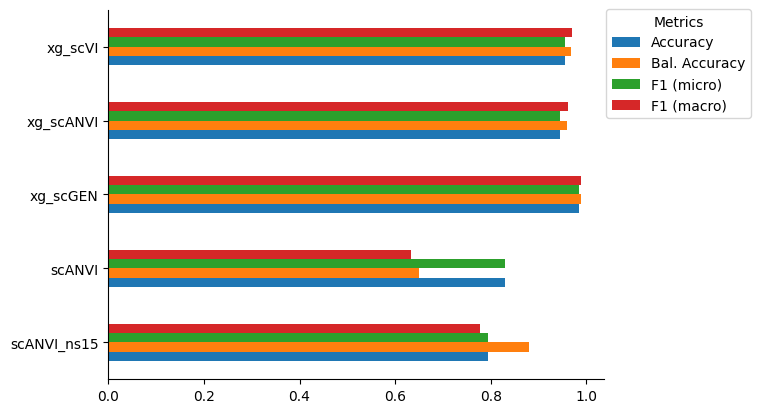

In [11]:
mouse_accuracy.loc[CLFS_ORDER[::-1]].plot(kind='barh')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.gca().legend(title='Metrics', bbox_to_anchor=(0.99, 1.02), loc='upper left')

In [ ]:
icm_accuracy = (sc.metrics.confusion_matrix('ct', 'scANVI_ns15', data=predictions).loc['E3.5-ICM'] * 100).round()
icm_accuracy = icm_accuracy[icm_accuracy != 0].sort_values()

fig = plt.figure(figsize=[4.5,4.5])
ax = fig.add_subplot(111)
squarify.plot(sizes=icm_accuracy, 
              label=icm_accuracy.index + '\n(' + icm_accuracy.values.astype(str) + ')%', 
              color=[mouse_ct_colors[ct] for ct in icm_accuracy.index],
              text_kwargs={'fontsize': '10'}, ax=ax
             )
_ = plt.axis("off")
plt.title('ICM prediction composition')
fig.savefig("../figures/mouse/05_ICM_prediction_zoom.svg")

In [ ]:
mouse_subset = mouse[predictions[(predictions.ct == "E3.5-ICM") & (predictions.scANVI_ns15.isin(icm_accuracy.index))].index].copy()
mouse_subset.obs['scANVI_ns15'] = predictions.loc[mouse_subset.obs_names, 'scANVI_ns15']
sc.pl.dotplot(mouse_subset, ['gata6', 'nanog', 'sox2', 'pou5f1', 'cdx2', 'pdgfra'], groupby='scANVI_ns15', use_raw=True, standard_scale='var')

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=[20, 6], sharey=True, sharex=False)
for idx, clf in enumerate(CLFS_ORDER):
    conf_df = pd.DataFrame(0, index=predictions.ct.cat.categories, columns=predictions.ct.cat.categories) + sc.metrics.confusion_matrix('ct', clf, data=predictions)
    conf_df = conf_df.fillna(0)[predictions.ct.cat.categories]
    sns.heatmap(conf_df, linewidths=0.2, cmap='viridis', ax=ax[idx], square=True, cbar=None)
    ax[idx].set_title(clf)
    ax[idx].set_xticklabels(predictions.ct.cat.categories.tolist(), rotation=45, ha="right", rotation_mode="anchor")

fig.colorbar(cm.ScalarMappable(norm=Normalize(0,1), cmap='viridis'), ax=ax.ravel(), fraction=0.048)
fig.supxlabel('Predicted')
fig.supylabel('Observed')
fig.tight_layout()
fig.savefig("../figures/mouse/05_clf_confusion_mat.svg")

## Suppl. Table 2

In [ ]:
writer = pd.ExcelWriter("../results/suppl-tab-2.xlsx", engine="xlsxwriter")

pd.read_csv("../results/05_mouse_classifier_stats.csv", index_col=0).to_excel(writer, sheet_name="mouse_overall")
for clf in mouse_accuracy.index:
    df = pd.DataFrame(0, index=predictions.ct.cat.categories, columns=predictions.ct.cat.categories) + sc.metrics.confusion_matrix('ct', clf, data=predictions)
    df = df.fillna(0)[predictions.ct.cat.categories]
    df.to_excel(writer, sheet_name=f"mouse_{clf}")
writer.close()